<h1> What is the best area for setting up an Asian restaurant in Queens, Newyork?</h1>
<h5><h5>This notebook is created as an assignment for the Capstone Project in Coursera course</h5>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<hr>
<ul>
<li> WEEK 1
    <ol> <li>Problem definition</li>
         <li>Problem Statement</li>
         <li>Data Collection</li>
    </ol>
</li>
    
<li>WEEK 2</li>
<ol> <li>   Problem formulation</li>
     <li>   Results and Comparisons</li>
    <li>    Conclusions</li>
</ol>
</ul>
<hr>
</div>

<h3>Introduction: Business Problem </h3>
The objective is to help an entrepreneur to find the best place to open a new gastronomic Asian restaurant in Queens. For this study we consider the "restaurant market" is very mature in Queens. It means that we will consider that places where the number of restaurant is very low i-e locations with low potential (e.g. residential places) and not locations with high potential. For Queens, the notion of city center does not really exist so we cannot measure the distance between potential locations and a "city center". As a result, the approach taken to solve the problem will be the following one:
<ol>
    <li>find zones with a certain density of restaurants</li>
<li>segment those zones in order to find different profiles (e.g. Asian/Chinese profile, Latin/Italian profile, TexMex...)</li>
<li>within each profile/segment, assess the potential of each zone (e.g. a zone being tagged as Latin/Italian with fewer Italian restaurant than average)</li>

<h4> Data Collection</h4>
The first need is to have a map of Queens (with neighborhoods, coordinates of Queens' frontiers...).
Based on this map, we will first define zones: a zone being defined as a perimeter around a given place.
<ul>
<li>We will then create a grid, within Queens' frontiers, with a certain distance (e.g. d = 500m) between nodes and make sure zones cover the full area (at this stage we do not care if zones overlap) : the radius of each zone will be equal to d/sqrt(2).</li>
<li>For each zone we will retrieve the list of restaurants (whatever the type) using Foursquare data. We will then compute the density of each type of restaurant and segment/cluster the different zones.</li>
<li>Among the different clusters, we will be interested by zones with a "lack" of Asian restaurants: this lack will be computed as the distance between the density of Asian restaurants of the zone and the average of the same density for the cluster, only for zones being under the average.</li>
<li>Once zones with the best potential have been found, we will get the ratings of the Asian restaurants of the top 20 zones in order to assess the quality of the future competitors.</li>
In order to let the entrepreneur decide, the results of the study will be displayed as a map, with zones colored depending on their potential, and restaurants with good ratings (>8) displayed on the map for the top 20 zones

<h4> Simulation</h4>

In [18]:
import numpy as np # library to handle data in a vectorized manner
import random
import math
!pip install pyproj
import pyproj


import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.5f}'.format

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

print('Libraries imported.')

     |████████████████████████████████| 10.1MB 11.5MB/s eta 0:00:01
Libraries imported.


In [19]:
!pip install shapely
from shapely.geometry import Polygon, Point
from shapely.ops import cascaded_union

     |████████████████████████████████| 1.5MB 14.2MB/s eta 0:00:01


In [20]:
!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Let's create a grid over Manhattan map. The distance between nodes will be set to 400m in order to make sure the number of restaurants in each zone is under 100 (Foursquare limitation)

In order to make Folium and Foursquare work together, we will need to convert Cartesian 2D coordinate to longitude/latitude degrees

In [21]:
def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=18, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=18, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

In [22]:
!wget -q -O 'new_york.geojson' https://raw.githubusercontent.com/Aurelrobert/Coursera_Capstone/master/NY.geojson
print('Data downloaded!')

Data downloaded!


In [23]:
#as we are concerned with the features set so assigning that column to neighborhood data
with open('new_york.geojson') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']

Get all the neigborhoods along their frontiers

In [24]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude', 'Polygon'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['neighborhood']
        
    neighborhood_polygon = Polygon(data['geometry']['coordinates'][0])
    neighborhood_lon, neighborhood_lat = neighborhood_polygon.centroid.coords[0]  
    neighborhoods = neighborhoods.append({'Borough': borough,
                                              'Neighborhood': neighborhood_name,
                                              'Latitude': neighborhood_lat,
                                              'Longitude': neighborhood_lon,
                                              'Polygon': neighborhood_polygon,
                                             }, ignore_index=True)

In [25]:
neighborhoods.head()

Borough     Neighborhood  Latitude  Longitude  \
0          Bronx         Allerton  40.86473  -73.85998   
1         Queens  Alley Pond Park  40.75026  -73.74451   
2  Staten Island    Arden Heights  40.55481  -74.17946   
3  Staten Island        Arlington  40.64295  -74.15975   
4  Staten Island         Arrochar  40.59319  -74.07218   

                                             Polygon  
0  POLYGON ((-73.84859700000018 40.87167000000012...  
1  POLYGON ((-73.74333268196389 40.7388830992604,...  
2  POLYGON ((-74.169827 40.56107800000017, -74.16...  
3  POLYGON ((-74.15974815874296 40.64141652579018...  
4  POLYGON ((-74.06077989345394 40.59318800468343...

In [27]:
#Keeping only Queens' neighborhood
Queens = neighborhoods[neighborhoods['Borough']=='Queens']
Queens.head()

Borough     Neighborhood  Latitude  Longitude  \
1   Queens  Alley Pond Park  40.75026  -73.74451   
5   Queens          Arverne  40.59338  -73.79549   
6   Queens          Astoria  40.76519  -73.91975   
10  Queens      Bay Terrace  40.78477  -73.78314   
13  Queens          Bayside  40.75818  -73.76789   

                                              Polygon  
1   POLYGON ((-73.74333268196389 40.7388830992604,...  
5   POLYGON ((-73.78953462130708 40.5999718149268,...  
6   POLYGON ((-73.90160305064738 40.76777029715587...  
10  POLYGON ((-73.77065232675173 40.78207815541823...  
13  POLYGON ((-73.7456631440827 40.7515780164934, ...

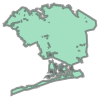

In [28]:
#plotting the area
Queens_poly = cascaded_union(Queens['Polygon'].to_list())
Queens_poly

Now lets create the grid over Queens Map. Each zone that doesnot intersect with Queens is excluded

In [35]:
LIMIT = 100
nodes_distance = 400 #distance in meters between 2 nodes
radius = nodes_distance / math.sqrt(3) #radius of each zone in order to make sure the full surface is covered

k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_step = nodes_distance
y_step = nodes_distance * k
Queens_nodes = []
ini_x, cur_y = lonlat_to_xy(Queens_poly.bounds[0], Queens_poly.bounds[1])
end_x, end_y = lonlat_to_xy(Queens_poly.bounds[2], Queens_poly.bounds[3])
cur_row = 0
while cur_y < end_y:
    x_offset = x_step/2 if cur_row%2==0 else 0
    cur_x = ini_x - x_offset
    cur_row += 1
    while cur_x < end_x:
        node = Point(xy_to_lonlat(cur_x, cur_y))
        cur_x += x_step
        if Queens_poly.intersects(node.buffer(xy_to_lonlat(0,nodes_distance/2)[1] - xy_to_lonlat(0,0)[1])):
            Queens_nodes.append(node)
    cur_y += y_step
print("{} nodes created".format(len(Queens_nodes)))

2307 nodes created


Lets define a draw_map function is order to display easily Manhattan maps for the rest of the study

In [41]:
def draw_map(data, latitude='Latitude', longitude='Longitude', z_value=None, cluster=None, labels=None, separator=", ", zoom=11, radius=radius, show_radius=False, show_marker=True):
    my_map = folium.Map(location=[(data[latitude].max() + data[latitude].min())/2, (data[longitude].max() + data[longitude].min())/2], zoom_start=zoom)
    #z_value: column name for the z_value, to display Circles / CircleMarkers in different colors based on their value
    #cluster: display Circles in different color based on the cluster value (if no z_value provided)
    
    if not z_value is None:
        # set color scheme for z_values
        values = minmax_scale(data[z_value])
        color_list = [colors.rgb2hex(cm.RdYlGn(v)) for v in values]
        
    if not cluster is None:
        nb_colors = len(data[data[cluster].notna()][cluster].unique())

        # set color scheme for the clusters
        colors_array = cm.rainbow(np.linspace(0, 1, nb_colors))
        rainbow = [colors.rgb2hex(i) for i in colors_array]
        color_list = data[data[cluster].notna()][cluster].map(lambda x: rainbow[int(x)-1]).values.tolist()
    
    # add markers to map
    for index, row in data.reset_index().iterrows():
        if not labels is None:
            label = separator.join(["{}: ".format(lab) + str(row[lab]) for lab in labels])
            if not cluster is None:
                label = label + separator + "Cluster: {}".format(row[cluster])
            if not z_value is None:
                label = label + separator + "{}: {}".format(z_value, row[z_value])
            label = folium.Popup(label, parse_html=True)
        else:
            label = None
        
        if not z_value is None:
            if np.isnan(row[z_value]):
                color = "#666666"
            else:
                color = color_list[index]
        else:
            if not cluster is None:
                if np.isnan(row[cluster]):
                    color = "#666666"
                else:
                    color = color_list[int(row[cluster])]
                    color = rainbow[int(row[cluster])-1]
            else:
                color = 'blue'
        if show_radius:
            if show_marker:
                opacity = 0.3
                fill_opacity = 0.2
            else:
                opacity = 1
                fill_opacity = 0.8
            folium.Circle(
                [row[latitude], row[longitude]],
                radius=radius,
                color=color,
                opacity=opacity,
                fill=True,
                fill_color=color,
                fill_opacity=fill_opacity).add_to(my_map) 
        if show_marker:
                folium.CircleMarker(
                [row[latitude], row[longitude]],
                radius=5,
                popup=label,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.7,
                parse_html=False).add_to(my_map)
    return my_map


In [42]:
radius = nodes_distance / math.sqrt(3)
Queens_nodes_df = pd.DataFrame([[node.x, node.y] for node in Queens_nodes])
Queens_nodes_df.columns = ["Longitude", "Latitude"]
Queens_nodes_df.index.name = "Node"
draw_map(Queens_nodes_df, zoom=12, show_radius=True, radius=radius)

Connecting to Foursquare

In [49]:
CLIENT_ID = 'JEWLZ3GG5ZLQIB5A0MQFBGVPDDWFZXI00QZXILPCFFJWJDJX' # your Foursquare ID
CLIENT_SECRET = 'CEGMPUQT22DPBBX5RH1LKYGDLIX2LP0F33EYAEXGMLGLMIEF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JEWLZ3GG5ZLQIB5A0MQFBGVPDDWFZXI00QZXILPCFFJWJDJX
CLIENT_SECRET:CEGMPUQT22DPBBX5RH1LKYGDLIX2LP0F33EYAEXGMLGLMIEF


In [50]:
def getNearbyVenues(nodes, latitudes, longitudes, radius=radius, section='food'):
    
    venues_list=[]
    for node, lat, lng in zip(nodes, latitudes, longitudes):
        print(node, end=" ")
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            section,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        try:
            results = results["response"]['groups'][0]['items']
            print("({})".format(len(results)), end=" | ")
            # return only relevant information for each nearby venue
            venues_list.append([(
                node, 
                lat, 
                lng, 
                v['venue']['id'], 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            print(results)
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Node', 
                  'Node Latitude', 
                  'Node Longitude', 
                  'Venue ID', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [51]:
Queens_venues = getNearbyVenues(nodes=Queens_nodes_df.index,
                                   latitudes=Queens_nodes_df['Latitude'],
                                   longitudes=Queens_nodes_df['Longitude']
                                  )

0 (0) | 1 (0) | 2 (0) | 3 (0) | 4 (0) | 5 (0) | 6 (0) | 7 (0) | 8 (0) | 9 (0) | 10 (0) | 11 (0) | 12 (0) | 13 (0) | 14 (0) | 15 (0) | 16 (0) | 17 (0) | 18 (0) | 19 (0) | 20 (0) | 21 (0) | 22 (0) | 23 (0) | 24 (0) | 25 (0) | 26 (1) | 27 (0) | 28 (0) | 29 (0) | 30 (0) | 31 (0) | 32 (0) | 33 (0) | 34 (1) | 35 (1) | 36 (3) | 37 (0) | 38 (0) | 39 (0) | 40 (0) | 41 (0) | 42 (0) | 43 (0) | 44 (0) | 45 (0) | 46 (0) | 47 (0) | 48 (0) | 49 (0) | 50 (0) | 51 (0) | 52 (0) | 53 (0) | 54 (3) | 55 (0) | 56 (0) | 57 (3) | 58 (0) | 59 (2) | 60 (2) | 61 (5) | 62 (0) | 63 (1) | 64 (0) | 65 (0) | 66 (0) | 67 (0) | 68 (0) | 69 (0) | 70 (1) | 71 (1) | 72 (0) | 73 (0) | 74 (0) | 75 (0) | 76 (0) | 77 (0) | 78 (0) | 79 (0) | 80 (0) | 81 (0) | 82 (0) | 83 (0) | 84 (0) | 85 (0) | 86 (0) | 87 (1) | 88 (1) | 89 (8) | 90 (1) | 91 (2) | 92 (7) | 93 (0) | 94 (0) | 95 (0) | 96 (0) | 97 (0) | 98 (15) | 99 (7) | 100 (2) | 101 (4) | 102 (1) | 103 (3) | 104 (1) | 105 (0) | 106 (4) | 107 (24) | 108 (2) | 109 (1) | 110 (0) 

Number of restaurants in each zone

In [96]:
number_venues = Queens_venues.groupby('Node').count()[['Venue']]
number_venues.columns = ['Node Number Venues']
number_venues.describe()

Node Number Venues
count           705.00000
mean              4.34184
std               4.64670
min               1.00000
25%               1.00000
50%               3.00000
75%               5.00000
max              38.00000

<h4>Methodology </h4>
Now we have all Manhattan venues, we will first segment the differents zones in order to identify zones profiles. Segmentation of zones is based on the different restaurant types density. In order to have a significant number of restaurants in the zone, we keep only the 2 first quartiles (i.e. zones with more than 13 restaurants)

Then, for each cluster we will consider that zones having a density under the cluster average (for a given type of restaurant) has a potential to increase.
This will give the list of 20 zones (with the highest potential) we will focus on.

For the selected zones, we will then retrieve the ratings of the potential competitors in order to find the best place to open a nwe restaurant (i.e. not too close from a competitor with a good rating - i.e. more than 8).

Results will be displayed in a map, with the 20 selected zones and the places where the competitors are located.

<h4>Analysis</h4> 
Let's start by segmenting our zones. We keep only zones with more than 13 restaurants.

In [100]:
def node_profile(neighborhood_venues):
    temp_df = pd.get_dummies(neighborhood_venues[['Venue Category']], prefix="", prefix_sep="")

    temp_df['Node'] = neighborhood_venues['Node'] 

    # move neighborhood column to the first column
    fixed_columns = [temp_df.columns[-1]] + list(temp_df.columns[:-1])
    temp_df = temp_df[fixed_columns]

    return temp_df.groupby('Node').mean().reset_index()

In [101]:
node_profiles = node_profile(Queens_venues[Queens_venues['Node Number Venues']>13])
node_profiles.head()

Node  American Restaurant  Arepa Restaurant  Argentinian Restaurant  \
0    98              0.00000           0.00000                 0.00000   
1   107              0.00000           0.04167                 0.00000   
2   396              0.00000           0.00000                 0.00000   
3   398              0.10345           0.00000                 0.00000   
4   422              0.05000           0.00000                 0.00000   

   Asian Restaurant  BBQ Joint  Bagel Shop  Bakery  Bistro  \
0           0.00000    0.00000     0.06667 0.00000 0.00000   
1           0.00000    0.08333     0.08333 0.00000 0.00000   
2           0.00000    0.00000     0.00000 0.00000 0.07143   
3           0.00000    0.00000     0.00000 0.06897 0.00000   
4           0.00000    0.00000     0.05000 0.05000 0.00000   

   Brazilian Restaurant  Breakfast Spot  Burger Joint  Burrito Place  \
0               0.00000         0.00000       0.00000        0.00000   
1               0.04167         0.04167       0.00000        0.04167   
2               0.00000         0.00000       0.00000        0.00000   
3               0.00000         0.00000       0.03448        0.03448   
4               0.00000         0.10000       0.15000        0.00000   

   Cafeteria    Café  Caribbean Restaurant  Chinese Restaurant  Churrascaria  \
0    0.00000 0.00000               0.00000             0.06667       0.00000   
1    0.00000 0.00000               0.00000             0.04167       0.00000   
2    0.00000 0.14286               0.00000             0.07143       0.00000   
3    0.00000 0.03448               0.00000             0.03448       0.00000   
4    0.00000 0.00000               0.00000             0.00000       0.00000   

   Colombian Restaurant  Creperie  Deli / Bodega  Dim Sum Restaurant   Diner  \
0               0.00000   0.00000        0.13333             0.00000 0.06667   
1               0.04167   0.00000        0.00000             0.00000 0.00000   
2               0.00000   0.00000        0.00000             0.00000 0.00000   
3               0.00000   0.00000        0.00000             0.00000 0.03448   
4               0.00000   0.00000        0.00000             0.00000 0.00000   

   Donut Shop  Dumpling Restaurant  Eastern European Restaurant  \
0     0.06667              0.00000                      0.00000   
1     0.00000              0.00000                      0.04167   
2     0.00000              0.00000                      0.00000   
3     0.10345              0.00000                      0.00000   
4     0.05000              0.00000                      0.00000   

   Egyptian Restaurant  Empanada Restaurant  Fast Food Restaurant    Food  \
0              0.00000              0.00000               0.00000 0.00000   
1              0.00000              0.00000               0.08333 0.00000   
2              0.00000              0.00000               0.07143 0.00000   
3              0.00000              0.00000               0.03448 0.00000   
4              0.00000              0.00000               0.00000 0.00000   

   Food Court  Food Truck  Fried Chicken Joint  Gastropub  Greek Restaurant  \
0     0.00000     0.00000              0.00000    0.00000           0.00000   
1     0.00000     0.08333              0.00000    0.00000           0.00000   
2     0.00000     0.00000              0.00000    0.00000           0.00000   
3     0.03448     0.00000              0.03448    0.03448           0.03448   
4     0.00000     0.00000              0.00000    0.00000           0.00000   

   Halal Restaurant  Himalayan Restaurant  Hot Dog Joint  Indian Restaurant  \
0           0.00000               0.00000        0.00000            0.00000   
1           0.00000               0.00000        0.04167            0.00000   
2           0.00000               0.00000        0.14286            0.00000   
3           0.00000               0.00000        0.00000            0.00000   
4           0.00000               0.00000        0.000

In [102]:
#get the most common venues for each zone to simplify further processing
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


def node_top_venues(neigh_profile, num_top_venues = 10):

    indicators = ['st', 'nd', 'rd'] + (num_top_venues -3) * ['th']

    # create columns according to number of top venues
    columns = ['Node']
    for ind in np.arange(num_top_venues):
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))

    # create a new dataframe
    top_venues = pd.DataFrame(columns=columns)
    top_venues['Node'] = neigh_profile['Node']

    for ind in np.arange(neigh_profile.shape[0]):
        top_venues.iloc[ind, 1:] = return_most_common_venues(neigh_profile.iloc[ind, :], num_top_venues)

    return top_venues

In [103]:
def draw_elbow(features, k_max=10):
    plt.plot()

    distortions = []
    K = range(1, k_max)
    for k in K:
        print("{}...".format(k), end="")
        kmeanModel = KMeans(n_clusters=k).fit(features)
        distortions.append(sum(np.min(cdist(features, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / features.shape[0])

    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

1...2...3...4...5...6...7...8...9...10...11...12...13...14...

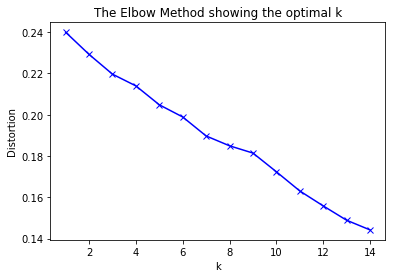

In [104]:
node_profiles_features = node_profiles.drop('Node', 1)
draw_elbow(node_profiles_features, 15)

In [105]:
#the number of clusters for rest of the study would be 10
# run k-means clustering
kmeans = KMeans(n_clusters=10, random_state=0).fit(node_profiles_features)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([0, 4, 5, 4, 4, 4, 5, 6, 2, 3, 5, 0, 3, 4, 7, 2, 5, 2, 2, 6],
      dtype=int32)

Build a Dataframe with nodes coordinates, most common venues, restaurant density and cluster labels



In [106]:
top_venus = node_top_venues(node_profiles)
top_venus.head()

Node 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0    98         Deli / Bodega   Japanese Restaurant            Steakhouse   
1   107  Fast Food Restaurant           Pizza Place            Food Truck   
2   396           Pizza Place         Hot Dog Joint                  Café   
3   398   American Restaurant            Donut Shop                Bakery   
4   422          Burger Joint           Pizza Place        Breakfast Spot   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0    Chinese Restaurant            Donut Shop            Restaurant   
1             BBQ Joint            Bagel Shop    Seafood Restaurant   
2                Bistro  Fast Food Restaurant    Mexican Restaurant   
3        Sandwich Place    Mexican Restaurant          Burger Joint   
4    Italian Restaurant        Sandwich Place   American Restaurant   

       7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0             Sandwich Place            Bagel Shop    Seafood Restaurant   
1  Latin American Restaurant         Burrito Place            Poke Place   
2         Chinese Restaurant           Snack Place            Restaurant   
3              Burrito Place                  Café    Chinese Restaurant   
4                 Steakhouse           Snack Place                Bakery   

  10th Most Common Venue  
0                  Diner  
1   Colombian Restaurant  
2     Turkish Restaurant  
3                  Diner  
4       Sushi Restaurant

In [107]:
# add clustering labels
top_venus.insert(0, 'Cluster Labels', kmeans.labels_)

node_merged = Queens_nodes_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
node_merged = node_merged.join(top_venus.set_index('Node'), on='Node')
node_merged = node_merged.join(node_profiles.set_index('Node'), on='Node')

node_merged[~node_merged['Cluster Labels'].isna()].head()


Longitude  Latitude  Cluster Labels 1st Most Common Venue  \
Node                                                              
98    -73.83913  40.58121         0.00000         Deli / Bodega   
107   -73.81781  40.58412         4.00000  Fast Food Restaurant   
396   -73.79075  40.64313         5.00000           Pizza Place   
398   -73.78129  40.64303         4.00000   American Restaurant   
422   -73.77414  40.64608         4.00000          Burger Joint   

     2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
Node                                                                     
98     Japanese Restaurant            Steakhouse    Chinese Restaurant   
107            Pizza Place            Food Truck             BBQ Joint   
396          Hot Dog Joint                  Café                Bistro   
398             Donut Shop                Bakery        Sandwich Place   
422            Pizza Place        Breakfast Spot    Italian Restaurant   

     5th Most Common Venue 6th Most Common Venue      7th Most Common Venue  \
Node                                                                          
98              Donut Shop            Restaurant             Sandwich Place   
107             Bagel Shop    Seafood Restaurant  Latin American Restaurant   
396   Fast Food Restaurant    Mexican Restaurant         Chinese Restaurant   
398     Mexican Restaurant          Burger Joint              Burrito Place   
422         Sandwich Place   American Restaurant                 Steakhouse   

     8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
Node                                                                      
98              Bagel Shop    Seafood Restaurant                  Diner   
107          Burrito Place            Poke Place   Colombian Restaurant   
396            Snack Place            Restaurant     Turkish Restaurant   
398                   Café    Chinese Restaurant                  Diner   
422            Snack Place                Bakery       Sushi Restaurant   

      American Restaurant  Arepa Restaurant  Argentinian Restaurant  \
Node                                                                  
98                0.00000           0.00000                 0.00000   
107               0.00000           0.04167                 0.00000   
396               0.00000           0.00000                 0.00000   
398               0.10345           0.00000                 0.00000   
422               0.05000           0.00000                 0.00000   

      Asian Restaurant  BBQ Joint  Bagel Shop  Bakery  Bistro  \
Node                                                            
98             0.00000    0.00000     0.06667 0.00000 0.00000   
107            0.00000    0.08333     0.08333 0.00000 0.00000   
396            0.00000    0.00000     0.00000 0.00000 0.07143   
398            0.00000    0.00000     0.00000 0.06897 0.00000   
422            0.00000    0.00000     0.05000 0.05000 0.00000   

      Brazilian Restaurant  Breakfast Spot  Burger Joint  Burrito Place  \
Node                                                                      
98                 0.00000         0.00000       0.00000        0.00000   
107                0.04167         0.04167       0.00000        0.04167   
396                0.00000         0.00000       0.00000        0.00000   
398                0.00000         0.00000       0.03448        0.03448   
422                0.00000         0.10000       0.15000        0.00000   

      Cafeteria    Café  Caribbean Restaurant  Chinese Restaurant  \
Node                                                                
98      0.00000 0.00000               0.00000             0.06667   
107     0.00000 0.00000               0.00000             0.04167   
396     0.00000 0.14286               0.00000             0.07143   
398     0.00000 0.03448               0.00000             0.03448   
422     0.00000 0.00000               0.000

In [108]:
draw_map(node_merged, zoom=12, labels=["Node"], cluster="Cluster Labels", separator=' | ', show_radius=True, show_marker=False, radius = nodes_distance/2)


Define the type or restaurant the entrepreneur wants to open. In our case, it is an Asian Restaurant.
As Chinese Places can also be competitors we will consider both Chinese Restaurant and Asian Place

In [112]:
new_restaurant_type = ["Chinese Restaurant", "Japanese Restaurant"]
node_merged["New Restaurant Type"] = node_merged[new_restaurant_type].sum(axis=1)
node_merged.head(20)

Longitude  Latitude  Cluster Labels 1st Most Common Venue  \
Node                                                              
0     -73.94137  40.54163             nan                   NaN   
1     -73.93896  40.54473             nan                   NaN   
2     -73.93423  40.54468             nan                   NaN   
3     -73.94127  40.54787             nan                   NaN   
4     -73.93655  40.54782             nan                   NaN   
5     -73.93182  40.54778             nan                   NaN   
6     -73.92710  40.54774             nan                   NaN   
7     -73.92238  40.54769             nan                   NaN   
8     -73.93886  40.55097             nan                   NaN   
9     -73.93414  40.55092             nan                   NaN   
10    -73.92941  40.55088             nan                   NaN   
11    -73.92469  40.55084             nan                   NaN   
12    -73.91996  40.55079             nan                   NaN   
13    -73.91524  40.55075             nan                   NaN   
14    -73.94117  40.55411             nan                   NaN   
15    -73.93645  40.55406             nan                   NaN   
16    -73.93172  40.55402             nan                   NaN   
17    -73.92700  40.55398             nan                   NaN   
18    -73.92228  40.55393             nan                   NaN   
19    -73.91755  40.55389             nan                   NaN   

     2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
Node                                                                     
0                      NaN                   NaN                   NaN   
1                      NaN                   NaN                   NaN   
2                      NaN                   NaN                   NaN   
3                      NaN                   NaN                   NaN   
4                      NaN                   NaN                   NaN   
5                      NaN                   NaN                   NaN   
6                      NaN                   NaN                   NaN   
7                      NaN                   NaN                   NaN   
8                      NaN                   NaN                   NaN   
9                      NaN                   NaN                   NaN   
10                     NaN                   NaN                   NaN   
11                     NaN                   NaN                   NaN   
12                     NaN                   NaN                   NaN   
13                     NaN                   NaN                   NaN   
14                     NaN                   NaN                   NaN   
15                     NaN                   NaN                   NaN   
16                     NaN                   NaN                   NaN   
17                     NaN                   NaN                   NaN   
18                     NaN                   NaN                   NaN   
19                     NaN                   NaN                   NaN   

     5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
Node                                                                     
0                      NaN                   NaN                   NaN   
1                      NaN                   NaN                   NaN   
2                      NaN                   NaN                   NaN   
3                      NaN                   NaN                   NaN   
4                      NaN                   NaN                   NaN   
5                      NaN                   NaN                   NaN   
6                      NaN                   NaN                   NaN   
7                      NaN                   NaN                   NaN   
8                      NaN                   NaN                   NaN   
9                      NaN                   NaN                   NaN   
10            

In [113]:
#compute the average density of chinese restaurants
restaurant_type_average_density = node_merged[['Cluster Labels', "New Restaurant Type"]].groupby(['Cluster Labels']).mean()
restaurant_type_average_density.columns= ['Cluster Average Dentity']
restaurant_type_average_density

Cluster Average Dentity
Cluster Labels                         
0.00000                         0.19840
1.00000                         0.00000
2.00000                         0.07955
3.00000                         0.09048
4.00000                         0.08923
5.00000                         0.07912
6.00000                         0.05911
7.00000                         0.05882
8.00000                         0.05556
9.00000                         0.11765

In [114]:
#merge it into global dataframe
node_merged = node_merged.join(restaurant_type_average_density, on='Cluster Labels')
node_merged[~node_merged['Cluster Labels'].isna()].head()

Longitude  Latitude  Cluster Labels 1st Most Common Venue  \
Node                                                              
98    -73.83913  40.58121         0.00000         Deli / Bodega   
107   -73.81781  40.58412         4.00000  Fast Food Restaurant   
396   -73.79075  40.64313         5.00000           Pizza Place   
398   -73.78129  40.64303         4.00000   American Restaurant   
422   -73.77414  40.64608         4.00000          Burger Joint   

     2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
Node                                                                     
98     Japanese Restaurant            Steakhouse    Chinese Restaurant   
107            Pizza Place            Food Truck             BBQ Joint   
396          Hot Dog Joint                  Café                Bistro   
398             Donut Shop                Bakery        Sandwich Place   
422            Pizza Place        Breakfast Spot    Italian Restaurant   

     5th Most Common Venue 6th Most Common Venue      7th Most Common Venue  \
Node                                                                          
98              Donut Shop            Restaurant             Sandwich Place   
107             Bagel Shop    Seafood Restaurant  Latin American Restaurant   
396   Fast Food Restaurant    Mexican Restaurant         Chinese Restaurant   
398     Mexican Restaurant          Burger Joint              Burrito Place   
422         Sandwich Place   American Restaurant                 Steakhouse   

     8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
Node                                                                      
98              Bagel Shop    Seafood Restaurant                  Diner   
107          Burrito Place            Poke Place   Colombian Restaurant   
396            Snack Place            Restaurant     Turkish Restaurant   
398                   Café    Chinese Restaurant                  Diner   
422            Snack Place                Bakery       Sushi Restaurant   

      American Restaurant  Arepa Restaurant  Argentinian Restaurant  \
Node                                                                  
98                0.00000           0.00000                 0.00000   
107               0.00000           0.04167                 0.00000   
396               0.00000           0.00000                 0.00000   
398               0.10345           0.00000                 0.00000   
422               0.05000           0.00000                 0.00000   

      Asian Restaurant  BBQ Joint  Bagel Shop  Bakery  Bistro  \
Node                                                            
98             0.00000    0.00000     0.06667 0.00000 0.00000   
107            0.00000    0.08333     0.08333 0.00000 0.00000   
396            0.00000    0.00000     0.00000 0.00000 0.07143   
398            0.00000    0.00000     0.00000 0.06897 0.00000   
422            0.00000    0.00000     0.05000 0.05000 0.00000   

      Brazilian Restaurant  Breakfast Spot  Burger Joint  Burrito Place  \
Node                                                                      
98                 0.00000         0.00000       0.00000        0.00000   
107                0.04167         0.04167       0.00000        0.04167   
396                0.00000         0.00000       0.00000        0.00000   
398                0.00000         0.00000       0.03448        0.03448   
422                0.00000         0.10000       0.15000        0.00000   

      Cafeteria    Café  Caribbean Restaurant  Chinese Restaurant  \
Node                                                                
98      0.00000 0.00000               0.00000             0.06667   
107     0.00000 0.00000               0.00000             0.04167   
396     0.00000 0.14286               0.00000             0.07143   
398     0.00000 0.03448               0.00000             0.03448   
422     0.00000 0.00000               0.000

Compute the improvement potential. We define it as the difference between the average density of the cluster and the density of the zone (floored to 0)



In [115]:
node_merged['Improvement Potential'] = (node_merged['Cluster Average Dentity'] - node_merged["New Restaurant Type"]).map(lambda x: max(x, 0))
node_merged['Improvement Potential'].replace(0, np.NaN, inplace=True)
node_merged[~node_merged['Cluster Labels'].isna()].head()

Longitude  Latitude  Cluster Labels 1st Most Common Venue  \
Node                                                              
98    -73.83913  40.58121         0.00000         Deli / Bodega   
107   -73.81781  40.58412         4.00000  Fast Food Restaurant   
396   -73.79075  40.64313         5.00000           Pizza Place   
398   -73.78129  40.64303         4.00000   American Restaurant   
422   -73.77414  40.64608         4.00000          Burger Joint   

     2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
Node                                                                     
98     Japanese Restaurant            Steakhouse    Chinese Restaurant   
107            Pizza Place            Food Truck             BBQ Joint   
396          Hot Dog Joint                  Café                Bistro   
398             Donut Shop                Bakery        Sandwich Place   
422            Pizza Place        Breakfast Spot    Italian Restaurant   

     5th Most Common Venue 6th Most Common Venue      7th Most Common Venue  \
Node                                                                          
98              Donut Shop            Restaurant             Sandwich Place   
107             Bagel Shop    Seafood Restaurant  Latin American Restaurant   
396   Fast Food Restaurant    Mexican Restaurant         Chinese Restaurant   
398     Mexican Restaurant          Burger Joint              Burrito Place   
422         Sandwich Place   American Restaurant                 Steakhouse   

     8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
Node                                                                      
98              Bagel Shop    Seafood Restaurant                  Diner   
107          Burrito Place            Poke Place   Colombian Restaurant   
396            Snack Place            Restaurant     Turkish Restaurant   
398                   Café    Chinese Restaurant                  Diner   
422            Snack Place                Bakery       Sushi Restaurant   

      American Restaurant  Arepa Restaurant  Argentinian Restaurant  \
Node                                                                  
98                0.00000           0.00000                 0.00000   
107               0.00000           0.04167                 0.00000   
396               0.00000           0.00000                 0.00000   
398               0.10345           0.00000                 0.00000   
422               0.05000           0.00000                 0.00000   

      Asian Restaurant  BBQ Joint  Bagel Shop  Bakery  Bistro  \
Node                                                            
98             0.00000    0.00000     0.06667 0.00000 0.00000   
107            0.00000    0.08333     0.08333 0.00000 0.00000   
396            0.00000    0.00000     0.00000 0.00000 0.07143   
398            0.00000    0.00000     0.00000 0.06897 0.00000   
422            0.00000    0.00000     0.05000 0.05000 0.00000   

      Brazilian Restaurant  Breakfast Spot  Burger Joint  Burrito Place  \
Node                                                                      
98                 0.00000         0.00000       0.00000        0.00000   
107                0.04167         0.04167       0.00000        0.04167   
396                0.00000         0.00000       0.00000        0.00000   
398                0.00000         0.00000       0.03448        0.03448   
422                0.00000         0.10000       0.15000        0.00000   

      Cafeteria    Café  Caribbean Restaurant  Chinese Restaurant  \
Node                                                                
98      0.00000 0.00000               0.00000             0.06667   
107     0.00000 0.00000               0.00000             0.04167   
396     0.00000 0.14286               0.00000             0.07143   
398     0.00000 0.03448               0.00000             0.03448   
422     0.00000 0.00000               0.000

In [116]:
node_merged[['Improvement Potential']].describe()


Improvement Potential
count               20.00000
mean                 0.02641
std                  0.02245
min                  0.00769
25%                  0.01090
50%                  0.01805
75%                  0.02975
max                  0.08923

Display the zones with their potential 
Note: Excluded and low potential zones are displayed in grey

In [117]:
draw_map(node_merged, zoom=12, z_value="Improvement Potential", show_radius=True, show_marker=False, radius = nodes_distance/2)


we see that Zones with high potential belong to different zones. Now
Keep only the top 20 zones



In [118]:
nodes_top20 = node_merged.nlargest(20, "Improvement Potential")
nodes_top20


Longitude  Latitude  Cluster Labels      1st Most Common Venue  \
Node                                                                   
422   -73.77414  40.64608         4.00000               Burger Joint   
1128  -73.82739  40.71216         6.00000  South American Restaurant   
1085  -73.82981  40.70907         0.00000                Pizza Place   
398   -73.78129  40.64303         4.00000        American Restaurant   
107   -73.81781  40.58412         4.00000       Fast Food Restaurant   
1091  -73.80140  40.70877         3.00000  Latin American Restaurant   
1338  -73.85316  40.72802         4.00000         Chinese Restaurant   
1170  -73.82970  40.71531         2.00000                 Food Truck   
877   -73.85138  40.69368         6.00000              Deli / Bodega   
945   -73.90808  40.70047         3.00000  Latin American Restaurant   
1007  -73.80625  40.70258         2.00000                Pizza Place   
946   -73.90335  40.70043         5.00000                Pizza Place   
1169  -73.83443  40.71535         0.00000         Chinese Restaurant   
947   -73.89861  40.70038         0.00000         Chinese Restaurant   
1135  -73.79425  40.71182         0.00000         Chinese Restaurant   
1336  -73.86263  40.72812         0.00000                Pizza Place   
1251  -73.84380  40.72169         4.00000                 Food Truck   
1004  -73.82045  40.70273         2.00000              Deli / Bodega   
396   -73.79075  40.64313         5.00000                Pizza Place   
807   -73.82309  40.68715         5.00000       Fast Food Restaurant   

         2nd Most Common Venue      3rd Most Common Venue  \
Node                                                        
422                Pizza Place             Breakfast Spot   
1128             Deli / Bodega       Fast Food Restaurant   
1085        Chinese Restaurant        American Restaurant   
398                 Donut Shop                     Bakery   
107                Pizza Place                 Food Truck   
1091     Sri Lankan Restaurant         Chinese Restaurant   
1338  Mediterranean Restaurant                Pizza Place   
1170  Mediterranean Restaurant  South American Restaurant   
877                Pizza Place  Latin American Restaurant   
945        American Restaurant                 Restaurant   
1007       Fried Chicken Joint         Chinese Restaurant   
946       Fast Food Restaurant                      Diner   
1169         Indian Restaurant         Mexican Restaurant   
947                Pizza Place            Thai Restaurant   
1135                Donut Shop          Indian Restaurant   
1336                    Bakery         Chinese Restaurant   
1251           Thai Restaurant               Burger Joint   
1004                      Food       Fast Food Restaurant   
396              Hot Dog Joint                       Café   
807                 Restaurant                 Donut Shop   

            4th Most Common Venue      5th Most Common Venue  \
Node                                                           
422            Italian Restaurant             Sandwich Place   
1128           Spanish Restaurant            Thai Restaurant   
1085                   Food Truck                 Donut Shop   
398                Sandwich Place         Mexican Restaurant   
107                     BBQ Joint                 Bagel Shop   
1091         Caribbean Restaurant                 Donut Shop   
1338                   Bagel Shop                 Restaurant   
1170                Deli / Bodega                Pizza Place   
877           Empanada Restaurant         Chinese Restaurant   
945            Chinese Restaurant             Sandwich Place   
1007                Deli / Bodega                 Restaurant   
946                 Deli / Bodega            Thai Restaurant   
1169                Deli / Bodega                 Bagel Shop   
947                 Deli / Bodega  Latin American Restaurant   
1135             Halal Restaurant       Fast Food Rest

Get all Chinese and Japanese eat outs to analyze the compitition in that specific area

In [119]:
competitors_list = Queens_venues[(Queens_venues['Venue Category'].isin(new_restaurant_type)) & (Queens_venues['Node'].isin(nodes_top20.index))]
print(competitors_list.shape)
competitors_list.head()

(31, 9)


Node  Node Latitude  Node Longitude                  Venue ID  \
92     107       40.58412       -73.81781  4d69549ede28224b0ac241be   
291    396       40.64313       -73.79075  4e4e12fbbd4101d0d7a199a0   
321    398       40.64303       -73.78129  4bc39a9874a9a5939fcbd4f6   
1098   807       40.68715       -73.82309  4bb50d3446d4a593807bc4c0   
1296   877       40.69368       -73.85138  4d8506089324236a6888c60e   

               Venue  Venue Latitude  Venue Longitude      Venue Category  \
92         Xing Xing        40.58481        -73.81943  Chinese Restaurant   
291       Manchu Wok        40.64173        -73.79255  Chinese Restaurant   
321    Panda Express        40.64205        -73.78316  Chinese Restaurant   
1098      Chopsticks        40.68599        -73.82517  Chinese Restaurant   
1296  Carnival House        40.69349        -73.85280  Chinese Restaurant   

      Node Number Venues  
92                    24  
291                   14  
321                   29  
1098                  14  
1296                  25

In [121]:
competitors_id_list = competitors_list['Venue ID'].unique()
def restaurants_rating(venue_id_list):
    df = pd.DataFrame(venue_id_list, columns=["Venue ID"])
    ratings=[]
    exceeded_quota = False
    for venue_id in venue_id_list:
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        if result['meta']['code'] != 200 and result['meta']['errorType']=='quota_exceeded':
            exceeded_quota = True
            ratings.append(round(max(0, min(random.gauss(6, 2), 10)), 1))
        else:
            result['response']['venue']
            try:
                ratings.append(result['response']['venue']['rating'])
            except:
                ratings.append(np.nan)
        print(venue_id, end=' | ')
    df["Rating"] = ratings
    if exceeded_quota:
        print("")
        print("!!! Quota Exceeded !!!")
    return df

Get the rating list of restaurants

In [122]:
competitors_rating = restaurants_rating(competitors_id_list)
competitors_rating.head()

4d69549ede28224b0ac241be | 4e4e12fbbd4101d0d7a199a0 | 4bc39a9874a9a5939fcbd4f6 | 4bb50d3446d4a593807bc4c0 | 4d8506089324236a6888c60e | 4c703259d97fa1434b58f5ca | 50aa6161e4b02938bfce3994 | 4ba25cdff964a52051f137e3 | 4c313b91452620a1005f200f | 4d7ad2e27ed8548152f66ed0 | 4d813abaa4e237043628c5cc | 4daf0d21cda1ea0bb04b3616 | 4c585bb82308be9ab3405b6c | 4c09da86ffb8c9b6b0bd6a61 | 4e4cd7b0bd413c4cc66c9a3b | 4ce49482e571a09332bc8587 | 4c90ffc5238c6dcbb754bc55 | 57b902d4498ea31e223ebd15 | 4fbfb2ece4b0a6eab8ea41b8 | 5c1ea48747f876003983d948 | 4d5d5f411ef2f04d44f5fecd | 4bc49c4dabf495216744c593 | 4bba1c4b1261d13a243cea98 | 5cd606aa0d173f002c3e3712 | 52545784498efe2a9bcc1698 | 4edac00e0aaf49e02a0e2f73 | 4bc6585351b376b0fa761b6f | 4c0d7f6ec700c9b6de84a2dd | 4bafed40f964a520152c3ce3 | 4d1d38e96e8c3704598fda9f | 

Venue ID  Rating
0  4d69549ede28224b0ac241be     nan
1  4e4e12fbbd4101d0d7a199a0     nan
2  4bc39a9874a9a5939fcbd4f6 4.90000
3  4bb50d3446d4a593807bc4c0 7.50000
4  4d8506089324236a6888c60e     nan

And merge it in the global venues list



In [124]:
rated_competitors = Queens_venues.join(competitors_rating.set_index('Venue ID'), on='Venue ID')
rated_competitors[~rated_competitors['Rating'].isna()].head()

Node  Node Latitude  Node Longitude                  Venue ID  \
321    398       40.64303       -73.78129  4bc39a9874a9a5939fcbd4f6   
1026   769       40.68406       -73.82551  4bb50d3446d4a593807bc4c0   
1098   807       40.68715       -73.82309  4bb50d3446d4a593807bc4c0   
1529   945       40.70047       -73.90808  4c703259d97fa1434b58f5ca   
1555   947       40.70038       -73.89861  4ba25cdff964a52051f137e3   

                   Venue  Venue Latitude  Venue Longitude      Venue Category  \
321        Panda Express        40.64205        -73.78316  Chinese Restaurant   
1026          Chopsticks        40.68599        -73.82517  Chinese Restaurant   
1098          Chopsticks        40.68599        -73.82517  Chinese Restaurant   
1529  Randy's Restaurant        40.70026        -73.90660  Chinese Restaurant   
1555             Mr Chen        40.70052        -73.89994  Chinese Restaurant   

      Node Number Venues  Rating  
321                   29 4.90000  
1026                   5 7.50000  
1098                  14 7.50000  
1529                  14 7.10000  
1555                  16 7.30000

Display the competitors on a map, with high potential zones displayed


In [125]:
top20_map = draw_map(nodes_top20, zoom=13, z_value="Improvement Potential", show_radius=True, show_marker=False, radius = radius)
for index, row in rated_competitors[(rated_competitors['Venue Category'].isin(new_restaurant_type)) | (rated_competitors['Node'].isin(nodes_top20.index))].iterrows():
    if row['Rating'] >= 8:
        color = '#FF0000'
        size = 3
    elif row['Rating'] < 8:
        color = '#FFFF00'
        size = 3
    elif row['Node'] in nodes_top20.index:
        color = '#0000FF'
        size = 1
    else:
        color = '#000000'
        size = 1
    folium.CircleMarker(
        [row['Venue Latitude'], row['Venue Longitude']],
        radius=size,
        popup="{} | {}".format(row['Venue'], row['Rating']),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        parse_html=False).add_to(top20_map)
top20_map


<h5>This map displays:</h5>

Top 20 zones with highest potential( with a color based on their potential, Green is the highest)
In the top 20 zones
<ul>
    <li>Competitors with a good rating (greater than equal) are displayed with a red marker</li>
    <li>Competitors with a low rating (less than 8)are displayed with a yellow marker </li>
    <li>Non-Asian restaurants are displayed in blue</li>
All the Chienese Restaurants and Japanese Places of Queens (in black).
The map also shows the density of Asian restaurant

<h4>Results and Discussion </h4>
Our analysis shows that we have zones with an interesting potential in different neighborhoods of Queens: the entrepreneur will have the choice between really differents options.

The study also shows that there are zones with very few (or no) Asian restaurants but have other kind of restaurants. In thoses places, the entrepeneur will have few competitors.
For zones with few Italian restaurants it is also interesting to check where the good competitors are. It is why we have displayed Asian restaurants with a rating greater than 8.

This study is just a starting point. It gives an overview of the potential interesting zones for opening an Italian Restaurant, but a deeped analysis is needed to understand why there is a lack of Asian Restaurants. Maybe due to less Asian population in a region an asian restaurant doenst exist in a certain place . so all factors should be considered.

<h4>Conclusion </h4>
Purpose of this project was to identify Queens' zones with a density of Asian restaurants under the average in order to find the optimal location for a new Italian restaurant.
By calculating restaurant density distribution from Foursquare data we have first identified area profiles (by clustering the zones), and then calculed for each zone if the density in Asian restaurant is under the average of its cluster or not. The distance between the density of the zone and the density of the cluster has given the growth potential of the zone. This analysis has given a list of 20 interesting zones for a deeper analysis.
We have then analysed the location of major competitors in order to make sure we do not recommend a zone surrounded by Asian restaurants with a very good rating.

Final decision on optimal restaurant location will be made by the entrepreneur based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location, levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.